[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1H20KzT5gd67i07NTBkP925ksVAQ-i7BE#scrollTo=KICTR2HtEcU9)

# About this notebook

In this notebook, we apply CIDRE to the original example code in order to replicate the original experiments and aid in validating the results.

**The purpose of this notebook is to simply demonstrate that the original CIDRE code is fully functional and has been replicated by a third party (myself, Gregory Pollard).**

# CITATION:

The code in this notebook and at its associated Github connection was entirely copied from the original CIDRE Github found [here](https://github.com/skojaku/cidre).


**Paper:** Detecting anomalous citation groups in journal networks

**Authors:** Kojaku, Sadamori and Livan, Giacomo and Masuda, Naoki

**Journal:** Sci. Rep.

**Publisher:** Nature Publishing Group

## Preparation

### Install CIDRE package

First, we install `cidre` package with `pip`:

In [ ]:
!pip install cidre

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached seaborn-0.11.1-py3-none-any.whl (285 kB)
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.11.2
    Uninstalling seaborn-0.11.2:
      Successfully uninstalled seaborn-0.11.2



### Loading libraries

Next, we load some libraries:

In [ ]:
import sys
import numpy as np
from scipy import sparse
import pandas as pd
import cidre
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

Finding communities requires the graph-tool package. This can be installed easily on Unix machines with:



```
conda install -c conda-forge graph-tool
```

Or, in Google Colab, we may use:

In [ ]:
%%capture
!echo "deb http://downloads.skewed.de/apt bionic main" >> /etc/apt/sources.list
!apt-key adv --keyserver keys.openpgp.org --recv-key 612DEFB798507F25
!apt-get update
!apt-get install python3-graph-tool python3-cairo python3-matplotlib


# Journals of 2020 Example

We apply CIDRE as in the original experiments but on the Microsoft Academic Graph Data set for the **new, unseen** journals of 2020.

In [ ]:
# Data path
edge_file = "https://raw.githubusercontent.com/gpollard647/CIDRE_Diss/main/Validation_Code/data/journal-citation/edge-table-2020.csv"

# Load edges
A, node_labels = cidre.utils.read_edge_list(edge_file)

## About this network

This network is a citation network of journals in 2020 constructed from Microsoft Academic Graph.
Each edge is weighted by the number of citations made to the papers in the prior two years.
The following are basic statistics of this network.

In [ ]:
print("Number of nodes: %d" % A.shape[0])
print("Number of edges: %d" % A.sum())
print("Average degree: %.2f" % (A.sum()/A.shape[0]))
print("Max in-degree: %d" % np.max(A.sum(axis = 0)))
print("Max out-degree: %d" % np.max(A.sum(axis = 1)))
print("Maximum edge weight: %d" % A.max())
print("Minimum edge weight: %d" % np.min(A.data))

Number of nodes: 29083
Number of edges: 8238276
Average degree: 283.27
Max in-degree: 197438
Max out-degree: 97620
Maximum edge weight: 14120
Minimum edge weight: 1


## Detecting anomalous groups in the network

[In the original CIDRE paper](https://www.nature.com/articles/s41598-021-93572-3), the authors identified the communities of journals using [graph-tool](https://graph-tool.skewed.de/). They defined a `detect_community()` function that finds the community membership of each journal using the non-parametric dcSBM. If natural, healthy communities are already known and identified by other means, the "group_membership" parameter allows the user to input this to CIDRE, however, if we want CIDRE to detect these communities for us, we pass `group_membership = None` so that `detect_community()` can be executed.


We detect the anomalous groups in the network with CIDRE:

In [ ]:
alg = cidre.Cidre(alpha = 0.01, min_edge_weight = 10)
groups = alg.detect(A, threshold=0.15)
print("The number of journals in the largest group: %d" % np.max([group.size() for group in groups]))
print("Number of groups detected: %d" % len(groups))

The number of journals in the largest group: 5792
Number of groups detected: 31


[In the orignal CIDRE paper](https://www.nature.com/articles/s41598-021-93572-3), the authors omitted the groups that have within-group citations less than 50 because we expect that anomalous citation groups contain sufficiently many within-group citations, i.e., 

In [ ]:
groups = [group for group in groups if group.get_num_edges()>=50 or group.size() > 50]
len_groups = len(groups)

where `group.get.num_edges()` gives the sum of the weights of the non-self-loop edges within the group.

## Visualization

Let us visualize the groups detected by CIDRE for the new, unseen 2020 MAG dataset. For expository purposes, we sample three groups to visualize uniformly at random.

In [ ]:
groups_sampled = [groups[i] for i in np.random.choice(len(groups), 3, replace = False)]

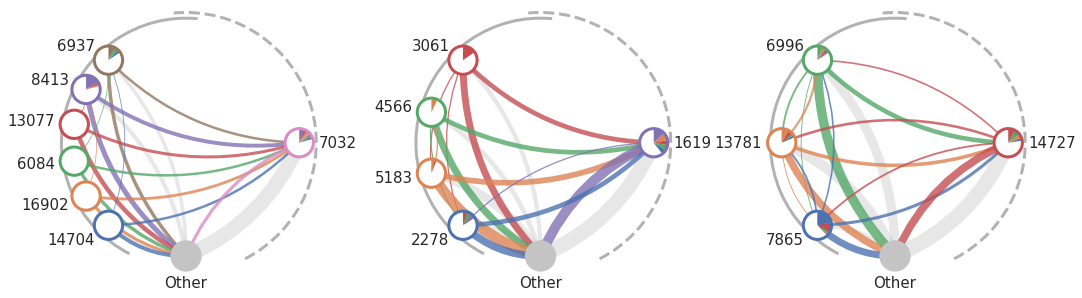

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("white")
sns.set(font_scale=1.2)
sns.set_style("ticks")

fig, axes = plt.subplots(ncols = 3, figsize=(6 * 3, 5))

for i in range(3):
    cidre.DrawGroup().draw(groups_sampled[i], ax = axes.flat[i])

The numbers beside the nodes are the IDs of the journals in the network. To show the journals' names, we do the following. 


First, we load node lables and make a dictionary that maps the ID of each node to the label:

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/gpollard647/CIDRE_Diss/main/Validation_Code/data/journal-citation/journals_of_interest.csv")
journalid2label = dict(zip(df.journal_id.values, df.name.values)) # Dictionary from MAG journal ID to the journal name
id2label = {k:journalid2label[v] for k, v in node_labels.items()} # This is a dictionary from ID to label, i.e., {ID:journal_name}

Then, give `id2label` to `cidre.DrawGroup.draw`, i.e.,  

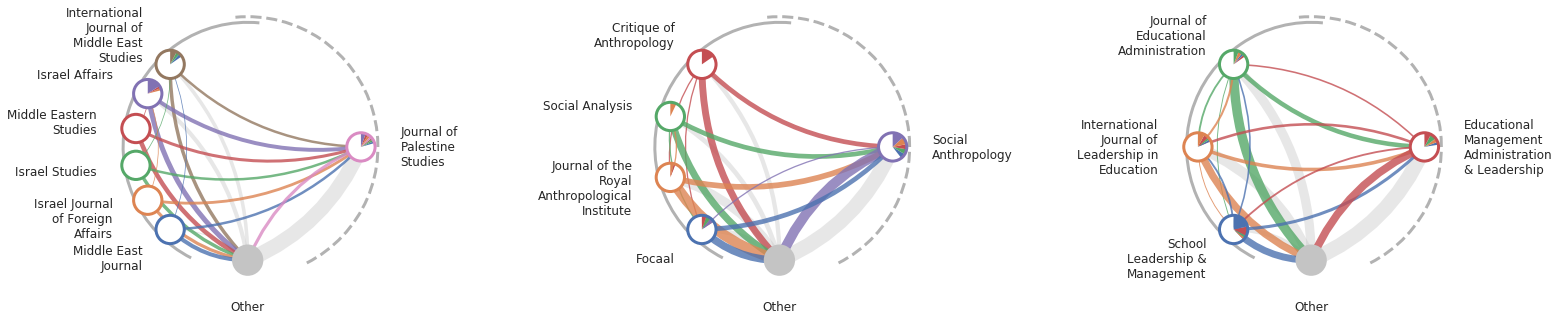

In [ ]:
sns.set_style("white")
sns.set(font_scale=1.2)
sns.set_style("ticks")

fig, axes = plt.subplots(ncols = 3, figsize=(9 * 3, 5))

for i in range(3):
    plotter = cidre.DrawGroup()
    plotter.font_size = 12 # Font size
    plotter.label_node_margin = 0.7 # Margin between labels and node
    plotter.draw(groups_sampled[i], node_labels = id2label, ax = axes.flat[i])